# DIRTY NOTEBOOK

##### Imports

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy import stats

#functions
import wrangle as w



warnings.filterwarnings("ignore")

#evaluate
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from statsmodels.formula.api import ols
import sklearn.preprocessing

#feature engineering
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

In [2]:
#wrangle is working now after adding tocsv and zillow17 to wrangle_zillow
df = w.wrangle_zillow()

In [4]:
df.head().T

parcelid,10711855,10711877,10711888,10711910,10711923
Unnamed: 0,0,1,2,3,4
bathrooms,2,2,2,2,2
bedrooms,3,4,4,3,4
property_quality,8,8,8,8,8
sqft,2107,1882,1882,1477,1918
fips,6037,6037,6037,6037,6037
latitude,3.42226e+07,3.42203e+07,3.42225e+07,3.42219e+07,3.42206e+07
longitude,-1.18617e+08,-1.18616e+08,-1.18617e+08,-1.18616e+08,-1.18615e+08
lot_sqft,9158,9035,9800,11285,11239
rawcensustractandblock,6.03711e+07,6.03711e+07,6.03711e+07,6.03711e+07,6.03711e+07


In [ ]:
def wrangle_zillow():
    """
    wrangle_zillow will:
    - read in zillow.csv acquired from SQL query
    - filter data to single unit homes with min 1B/1B 
    """
    df = pd.read_csv('zillow.csv')
    df = df.set_index("parcelid")
    # Restrict df to only properties that meet single-use criteria
    single_use = [260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 273, 275, 276, 279]
    df = df[df.propertylandusetypeid.isin(single_use)]
    # Filter those properties without at least 1 bath & bed and 500 sqft area
    df = df[(df.bedroomcnt > 0) & (df.bathroomcnt > 0) & ((df.unitcnt<=1)|df.unitcnt.isnull())\
            & (df.calculatedfinishedsquarefeet>500)]
    # Handle missing values i.e. drop columns and rows based on a threshold
    df = drop_based_on_pct(df, .6, .7)
    # Add column for counties
    df['county'] = np.where(df.fips == 6037, 'Los_Angeles',
                           np.where(df.fips == 6059, 'Orange',
                                   'Ventura'))
    # Drop unnecessary/redundant columns
    df = df.drop(['id',
       'calculatedbathnbr', 'finishedsquarefeet12', 'fullbathcnt', 'heatingorsystemtypeid'
       ,'propertycountylandusecode', 'propertylandusetypeid','propertyzoningdesc',
        'censustractandblock', 'propertylandusedesc', 'heatingorsystemdesc'],axis=1)
    # Replace nulls in unitcnt with 1
    df.unitcnt.fillna(1, inplace = True)
    # Replace nulls with median values for select columns
    df.lotsizesquarefeet.fillna(7265, inplace = True)
    df.buildingqualitytypeid.fillna(7.0, inplace = True)
    # Drop any remaining nulls
    df = df.dropna()
    # Columns that need to be adjusted for outliers
    df = df[df.taxvaluedollarcnt < 5_000_000]
    df = df[df.calculatedfinishedsquarefeet < 12500]
    # create column for age of home
    df['home_age'] = 2021 - df.yearbuilt
    # List of cols to convert to 'int'
    cols = ['fips', 'buildingqualitytypeid', 'bedroomcnt', 'roomcnt', 
            'home_age', 'yearbuilt', 'assessmentyear', 'regionidcounty', 
            'regionidzip', 'unitcnt', 'home_age']
    # loop through cols list in conversion
    for col in cols:
        df[col] = df[col].astype('int')
    # Rename columns
    df.rename(columns={"bathroomcnt": "bathrooms", 
                   "bedroomcnt": "bedrooms",
                   "buildingqualitytypeid": "property_quality", 
                   "calculatedfinishedsquarefeet": "sqft",
                   "lotsizesquarefeet": "lot_sqft",
                   "regionidzip": "zip_code",
                   "landtaxvaluedollarcnt": "land_value",
                   "structuretaxvaluedollarcnt": "structure_value",
                   "taxvaluedollarcnt ": "home_value"
                  }, inplace=True)
    # create a categorical version of target by splitting into quartiles
    df['logerror_quartiles'] = pd.qcut(df.logerror, q=4, labels=['q1', 'q2', 'q3', 'q4'])
    return df

In [ ]:
wrangle_zillow()

In [ ]:
from env import host, user, password

In [ ]:
def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'
def zillow17():
    '''
    This function reads in the zillow data from the Codeup db
    and returns a pandas DataFrame with:
    - all fields related to the properties that are available
    - using all the tables in the database
    - Only include properties with a transaction in 2017
    - include only the last transaction for each property
    - zestimate error
    - date of transaction
    - Only include properties that include a latitude and longitude value
    '''
    query = """
            SELECT prop.*,
                   pred.logerror,
                   pred.transactiondate,
                   air.airconditioningdesc,
                   arch.architecturalstyledesc,
                   build.buildingclassdesc,
                   heat.heatingorsystemdesc,
                   landuse.propertylandusedesc,
                   story.storydesc,
                   construct.typeconstructiondesc
            FROM   properties_2017 prop
            INNER JOIN (SELECT parcelid,
                               logerror,
                               Max(transactiondate) transactiondate
                        FROM   predictions_2017
                        GROUP  BY parcelid, logerror) pred
                     USING (parcelid)
            LEFT JOIN airconditioningtype air USING (airconditioningtypeid)
            LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid)
            LEFT JOIN buildingclasstype build USING (buildingclasstypeid)
            LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid)
            LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid)
            LEFT JOIN storytype story USING (storytypeid)
            LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid)
            WHERE prop.latitude IS NOT NULL
                  AND prop.longitude IS NOT NULL
                  AND transactiondate like '2017%'
    """
    return pd.read_sql(query, get_connection('zillow'))

In [ ]:
def drop_based_on_pct(df, pc, pr):
    """
    drop_based_on_pct takes in: 
    - dataframe, 
    - threshold percent of non-null values for columns(# between 0-1), 
    - threshold percent of non-null values for rows(# between 0-1)
    Returns: a dataframe with the columns and rows dropped as indicated.
    """
    tpc = 1-pc
    tpr = 1-pr
    df.dropna(axis = 1, thresh = tpc * len(df.index), inplace = True)
    df.dropna(axis = 0, thresh = tpr * len(df.columns), inplace = True)
    return df
def outlier(df, feature, m):
    '''
    outlier will take in a dataframe's feature:
    - calculate it's 1st & 3rd quartiles,
    - use their difference to calculate the IQR
    - then apply to calculate upper and lower bounds
    - using the `m` multiplier
    '''
    q1 = df[feature].quantile(.25)
    q3 = df[feature].quantile(.75)
    iqr = q3 - q1
    multiplier = m
    upper_bound = q3 + (multiplier * iqr)
    lower_bound = q1 - (multiplier * iqr)
    return upper_bound, lower_bound

In [ ]:
#added to_csv
#added acquire in here as well to run it all in one go
def wrangle_zillow():
    """
    wrangle_zillow will:
    - read in zillow.csv acquired from SQL query
    - filter data to single unit homes with min 1B/1B 
    """
    #df = zillow17()
    df = df.to_csv('zillow.csv')
    df = pd.read_csv('zillow.csv')
    df = df.set_index("parcelid")
    # Restrict df to only properties that meet single-use criteria
    single_use = [260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 273, 275, 276, 279]
    df = df[df.propertylandusetypeid.isin(single_use)]
    # Filter those properties without at least 1 bath & bed and 500 sqft area
    df = df[(df.bedroomcnt > 0) & (df.bathroomcnt > 0) & ((df.unitcnt<=1)|df.unitcnt.isnull())\
            & (df.calculatedfinishedsquarefeet>500)]
    # Handle missing values i.e. drop columns and rows based on a threshold
    df = drop_based_on_pct(df, .6, .7)
    # Add column for counties
    df['county'] = np.where(df.fips == 6037, 'Los_Angeles',
                           np.where(df.fips == 6059, 'Orange',
                                   'Ventura'))
    # Drop unnecessary/redundant columns
    df = df.drop(['id',
       'calculatedbathnbr', 'finishedsquarefeet12', 'fullbathcnt', 'heatingorsystemtypeid'
       ,'propertycountylandusecode', 'propertylandusetypeid','propertyzoningdesc',
        'censustractandblock', 'propertylandusedesc', 'heatingorsystemdesc'],axis=1)
    # Replace nulls in unitcnt with 1
    df.unitcnt.fillna(1, inplace = True)
    # Replace nulls with median values for select columns
    df.lotsizesquarefeet.fillna(7265, inplace = True)
    df.buildingqualitytypeid.fillna(7.0, inplace = True)
    # Drop any remaining nulls
    df = df.dropna()
    # Columns that need to be adjusted for outliers
    df = df[df.taxvaluedollarcnt < 5_000_000]
    df = df[df.calculatedfinishedsquarefeet < 12500]
    # create column for age of home
    df['home_age'] = 2021 - df.yearbuilt
    # List of cols to convert to 'int'
    cols = ['fips', 'buildingqualitytypeid', 'bedroomcnt', 'roomcnt', 
            'home_age', 'yearbuilt', 'assessmentyear', 'regionidcounty', 
            'regionidzip', 'unitcnt', 'home_age']
    # loop through cols list in conversion
    for col in cols:
        df[col] = df[col].astype('int')
    # Rename columns
    df.rename(columns={"bathroomcnt": "bathrooms", 
                   "bedroomcnt": "bedrooms",
                   "buildingqualitytypeid": "property_quality", 
                   "calculatedfinishedsquarefeet": "sqft",
                   "lotsizesquarefeet": "lot_sqft",
                   "regionidzip": "zip_code",
                   "landtaxvaluedollarcnt": "land_value",
                   "structuretaxvaluedollarcnt": "structure_value",
                   "taxvaluedollarcnt ": "home_value"
                  }, inplace=True)
    # create a categorical version of target by splitting into quartiles
    df['logerror_quartiles'] = pd.qcut(df.logerror, q=4, labels=['q1', 'q2', 'q3', 'q4'])
    return df

In [ ]:
wrangle_zillow()

In [5]:
df.latitude.value_counts()

33984600.0    40
33665651.0    38
33766300.0    34
34056700.0    32
34225100.0    29
              ..
33824319.0     1
33831289.0     1
34072215.0     1
34214434.0     1
33554486.0     1
Name: latitude, Length: 59332, dtype: int64

In [6]:
df.longitude.value_counts()

-118438000.0    63
-118435000.0    62
-118445000.0    60
-118377000.0    59
-118390000.0    57
                ..
-118274182.0     1
-118787757.0     1
-118038828.0     1
-118151045.0     1
-117692831.0     1
Name: longitude, Length: 57674, dtype: int64

In [10]:
df.home_age.mean()

51.43118716756245

In [11]:
df.home_age.min()

5

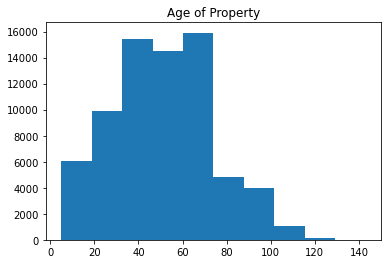

In [13]:
plt.hist(df['home_age'])
plt.title('Age of Property')
plt.show()